# Notes

"RGC, GlioB, NeuB, GluNeu, GluNeuB, GABA"

# Loda Modules

In [1]:
library(Giotto)
library(ggplot2)
library(pheatmap)
library(reshape2)
library(dplyr)

Loading required package: GiottoClass

Newer devel version of GiottoClass on GitHub: 0.4.1

Giotto Suite 4.1.1


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# wget https://github.com/drieslab/spatial-datasets/blob/master/data/2018_osmFISH_SScortex/count_matrix/osmFISH_prep_expression.txt
# wget https://github.com/drieslab/spatial-datasets/blob/master/data/2018_osmFISH_SScortex/cell_locations/osmFISH_prep_cell_coordinates.txt
# https://github.com/drieslab/spatial-datasets/blob/master/data/2022_miniseqFISH/mouse_ligand_receptors.txt

In [3]:
my_instructions = createGiottoInstructions(python_path = "/sc/arion/work/wangw32/conda-env/envs/giotto_suite/bin/python")

a python path has been provided

Using python path:
 "/sc/arion/work/wangw32/conda-env/envs/giotto_suite/bin/python"



# low

## create giotto object

In [4]:
# giotto_low = createGiottoObject(expression = '../E14_low_progenitor_exp.txt',
#                                       spatial_locs = '../E14_low_progenitor_loc.txt',
#                                       instructions = my_instructions)

giotto_low = createGiottoObject(expression = '../E14_low_exp.txt',
                                      spatial_locs = '../E14_low_loc.txt',
                                      instructions = my_instructions)

Warning message:
“Some of Giotto's expected python module(s) were not found:
pandas, igraph, leidenalg, community, networkx, sklearn
(This is fine if python-based functions are not needed)

** Python path used:
"/sc/arion/work/wangw32/conda-env/envs/giotto_suite/bin/python"”
Warning message in data.table::fread(input = spatial_locs, nThread = cores):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
# meta_low <- read.csv("../E14_low_progenitor_meta.txt", sep='\t')

meta_low <- read.csv("../E14_low_meta.txt", sep='\t')

In [6]:
table(meta_low$annot)


  Basal    Endo     Ery   Fibro    GABA   GlioB  GluNeu GluNeuB    NeuB     RGC 
      1       9      35      23      13      19       2      43      29     404 

In [7]:
meta_low$annot[! meta_low$annot %in% c('RGC', 'GlioB', 'NeuB', 'GluNeu', 'GluNeuB', 'GABA')] <- 'other'


In [8]:
df = data.frame(cell_types=meta_low$annot)
rownames(df) = giotto_low@cell_metadata$cell$rna$cell_ID

In [9]:
head(df)

,cell_types
,<chr>
E14_E1S3_170808,other
E14_E1S3_170916,other
E14_E1S3_170934,other
E14_E1S3_171016,GluNeuB
E14_E1S3_171024,GluNeuB
E14_E1S3_171025,other


In [10]:
giotto_low <- addCellMetadata(giotto_low, new_metadata = df)

## cell proximity

In [11]:
giotto_low = createSpatialNetwork(gobject = giotto_low, minimum_k = 2,
                maximum_distance_delaunay = 400)

In [12]:
giotto_low <- createSpatialNetwork(gobject = giotto_low, method = 'kNN', k = 5, name = 'spatial_network')

In [13]:
set.seed(seed = 2841)
cell_proximities_low = cellProximityEnrichment(gobject = giotto_low,
                   cluster_column = 'cell_types',
                   spatial_network_name = 'spatial_network',
                   adjust_method = 'fdr',
                   number_of_simulations = 1000)

In [14]:
saveRDS(cell_proximities_low, 'cell_proximities_4_low.rds')

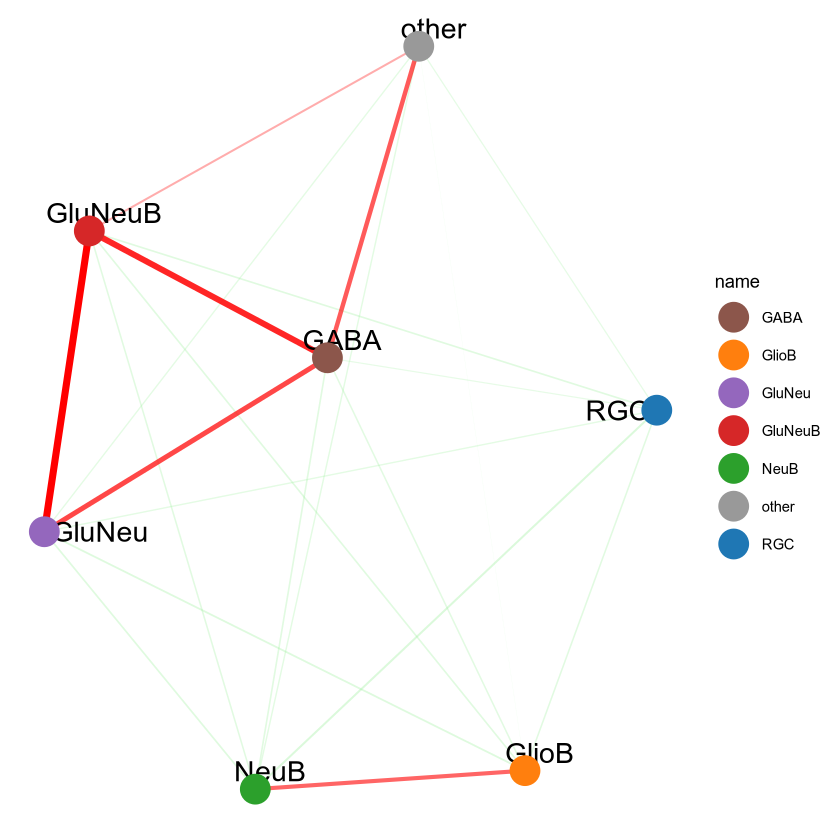

In [15]:
cellProximityNetwork(gobject = giotto_low, 
                     CPscore = cell_proximities_low,
                     remove_self_edges = T,
                     self_loop_strength = .3,
                     only_show_enrichment_edges = F,
                     rescale_edge_weights = T,
                     node_size = 8,
                     node_color_code = c('#8c564b', '#ff7f0e', '#9467bd', '#d62728', '#2ca02c', '#999999', '#1f77b4'), # GABA, GlioB, GluNeu, GluNeuB, NeuB, other, RGC
                     edge_weight_range_depletion = c(1, 2),
                     edge_weight_range_enrichment = c(2,5))
ggsave('CellProximityNetwork_low_4.pdf', width= 6, height=6)

## L-R

In [16]:
giotto_low <- filterGiotto(gobject = giotto_low,
                           expression_threshold = 1,
                           feat_det_in_min_cells = 10,
                           min_det_feats_per_cell = 10,
                           expression_values = c('raw'),
                           verbose = T)

completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results




Feature type:  rna 
Number of cells removed:  0  out of  578 
Number of feats removed:  13770  out of  19330 


In [17]:
# normalize
giotto_low <- normalizeGiotto(gobject = giotto_low, scalefactor = 6000, verbose = T)
# add gene & cell statistics
giotto_low <- addStatistics(gobject = giotto_low)
# adjust expression matrix for technical or known variables
giotto_low <- adjustGiottoMatrix(gobject = giotto_low, expression_values = c('normalized'),
                                 covariate_columns = c('nr_feats', 'total_expr'),
                                 return_gobject = TRUE,
                                 update_slot = c('custom'))


first scale feats and then cells



In [18]:
LR_data = data.table::fread("../../../../SpatComTrajectory/source/mouse_ligand_receptors.txt")
LR_data[, ligand_det := ifelse(LR_data$mouseLigand %in% giotto_low@feat_ID$rna, T, F)]
LR_data[, receptor_det := ifelse(LR_data$mouseReceptor %in% giotto_low@feat_ID$rna, T, F)]
LR_data_det = LR_data[ligand_det == T & receptor_det == T]
select_ligands = LR_data_det$mouseLigand
select_receptors = LR_data_det$mouseReceptor

In [19]:
## get statistical significance of gene pair expression changes based on expression
expr_only_scores_low = exprCellCellcom(gobject = giotto_low,
                                   cluster_column = 'cell_types', 
                                   random_iter = 1000,
                                   feat_set_1 = select_ligands,
                                   feat_set_2 = select_receptors, 
                                   verbose = FALSE)

In [20]:
## get statistical significance of gene pair expression changes upon cell-cell interaction
spatial_all_scores_low = spatCellCellcom(giotto_low,
                                     spatial_network_name = 'spatial_network',
                                     cluster_column = 'cell_types', 
                                     random_iter = 1000,
                                     feat_set_1 = select_ligands,
                                     feat_set_2 = select_receptors,
                                     adjust_method = 'fdr',
                                     do_parallel = T,
                                     cores = 4,
                                     verbose = 'a little')

In [21]:
saveRDS(giotto_low, 'giotto_low_4.rds')

In [22]:
saveRDS(spatial_all_scores_low, 'spatial_all_scores_low_4.rds')

In [23]:
giotto_low = readRDS('giotto_low_4.rds')
spatial_all_scores_low = readRDS('spatial_all_scores_low_4.rds')

In [24]:
head(spatial_all_scores_low)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Adam17-Itgb1,GlioB,0.3013547,Adam17,NeuB,1.0909136,Itgb1,1.3922683,7,10,0.4275697,0.964698581,1.50007336,0.024,GlioB--NeuB,0.2590000,0.880093395
Adam17-Itgb1,NeuB,0.0000000,Adam17,other,1.2462946,Itgb1,1.2462946,7,5,0.4044615,0.841833095,1.41617811,0.131,NeuB--other,0.8078333,0.131248882
Adam17-Itgb1,GlioB,0.2152533,Adam17,GlioB,0.6172454,Itgb1,0.8324987,14,14,0.7682069,0.064291862,0.10306293,0.625,GlioB--GlioB,1.0000000,0.000000000
Adam17-Itgb1,GABA,0.0000000,Adam17,other,0.7258348,Itgb1,0.7258348,12,12,0.4249860,0.300848840,0.65357435,0.432,GABA--other,0.8828966,0.035351954
Adam17-Itgb1,RGC,0.0000000,Adam17,GlioB,0.6847161,Itgb1,0.6847161,17,28,0.6785123,0.006203804,0.01145097,0.945,RGC--GlioB,0.9712500,0.000145072
Adam17-Itgb1,GluNeuB,0.1569827,Adam17,other,0.4749196,Itgb1,0.6319024,24,19,0.4817592,0.150143209,0.33122920,0.517,GluNeuB--other,0.8721429,0.019679112


Saving 6.67 x 6.67 in image


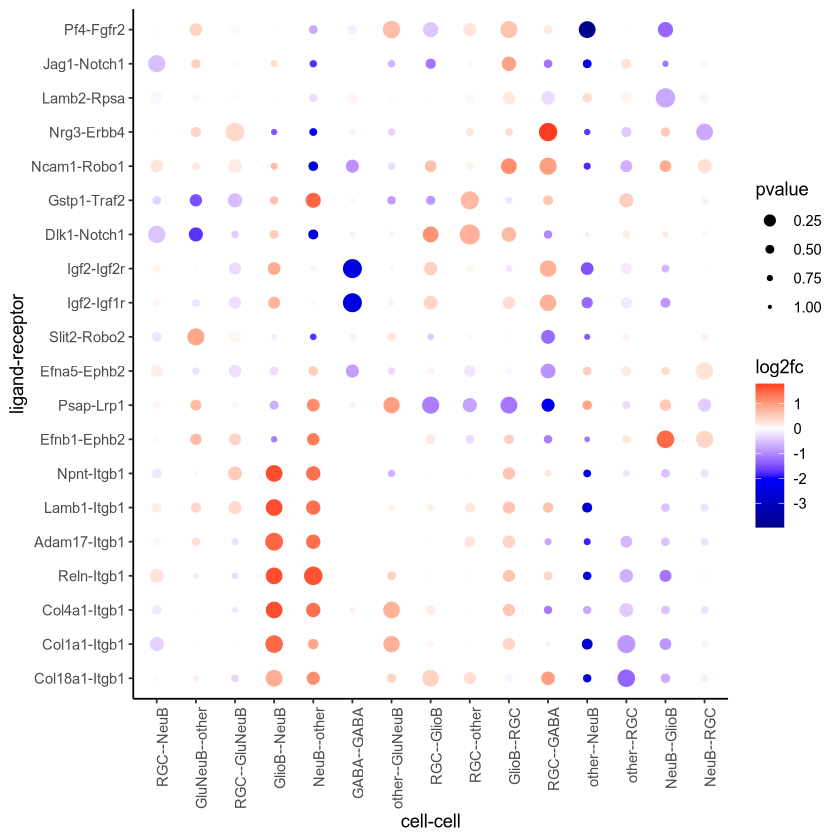

In [33]:
## select top LR ##
selected_spat = spatial_all_scores_low[pvalue <= 0.05 & abs(log2fc) > 0.25 & lig_nr >= 4 & rec_nr >= 4]
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]
plotCCcomDotplot(gobject = giotto_low,
                 comScores = spatial_all_scores_low,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 cluster_on = 'PI')
ggsave("Dotplot_low_4.pdf")

Saving 6.67 x 6.67 in image


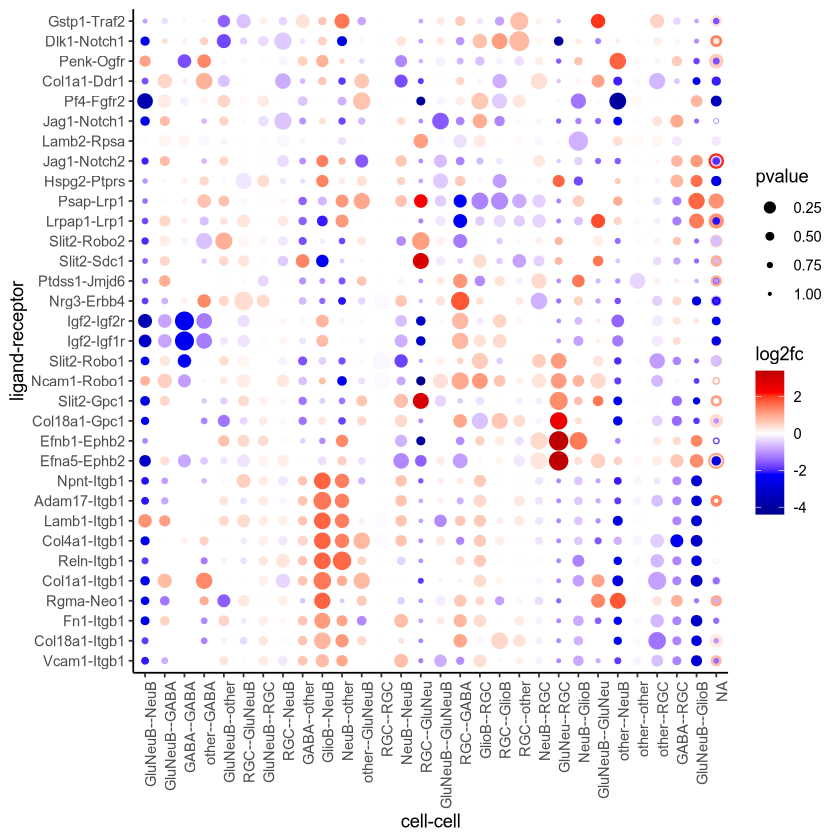

In [34]:
selected_spat = spatial_all_scores_low
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]
plotCCcomDotplot(gobject = giotto_low,
                 comScores = spatial_all_scores_low,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 cluster_on = 'PI')
ggsave("Dotplot_low_all_4.pdf")

In [35]:
giotto_low = readRDS('giotto_low_4.rds')
spatial_all_scores_low = readRDS('spatial_all_scores_low_4.rds')
cell_proximities_low = readRDS('cell_proximities_low_4.rds')

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cell_proximities_low_4.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [ ]:
write.csv(cell_proximities_low$enrichm_res, 'cell_proximities_low_4.csv')

In [ ]:
head(cell_proximities_low$enrichm_res)

In [ ]:
selected_spat = spatial_all_scores_low
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]


In [ ]:
gobject = giotto_low
comScores = spatial_all_scores_low
selected_LR = top_LR_ints
selected_cell_LR = top_LR_cell_ints
show_LR_names = TRUE
show_cell_LR_names = TRUE
cluster_on = 'PI'
cor_method = c("pearson", "kendall", "spearman")
aggl_method = c("ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", "centroid")
dot_color_gradient = NULL
gradient_style = c('divergent', 'sequential')
show_plot = NA
return_plot = NA
save_plot = NA
save_param =  list()
default_save_name = 'plotCCcomDotplot'

In [ ]:
# get parameters
cor_method = match.arg(cor_method, choices = c("pearson", "kendall", "spearman"))
aggl_method = match.arg(aggl_method, choices = c("ward.D", "ward.D2", "single", "complete",
                                               "average", "mcquitty", "median", "centroid"))


# data.table variables
LR_comb = LR_cell_comb = sd = NULL

# plot method
if(!is.null(selected_LR) & !is.null(selected_cell_LR)) {
selDT = comScores[LR_comb %in% selected_LR & LR_cell_comb %in% selected_cell_LR]
} else if(!is.null(selected_LR)) {
selDT = comScores[LR_comb %in% selected_LR]
} else if(!is.null(selected_cell_LR)) {
selDT = comScores[LR_cell_comb %in% selected_cell_LR]
} else {
selDT = comScores
}

In [ ]:
# creat matrix
cluster_on = match.arg(cluster_on, choices = c('PI', 'LR_expr', 'log2fc'))
selDT_d = data.table::dcast.data.table(selDT, LR_cell_comb~LR_comb, value.var = cluster_on, fill = 0)
selDT_m = dt_to_matrix(selDT_d)

# remove zero variance
sd_rows = apply(selDT_m, 1, sd)
sd_rows_zero = names(sd_rows[sd_rows == 0])
if(length(sd_rows_zero) > 0) selDT_m = selDT_m[!rownames(selDT_m) %in% sd_rows_zero, ]

sd_cols = apply(selDT_m, 2, sd)
sd_cols_zero = names(sd_cols[sd_cols == 0])
if(length(sd_cols_zero) > 0) selDT_m = selDT_m[, !colnames(selDT_m) %in% sd_cols_zero]

In [ ]:
## cells
corclus_cells_dist = stats::as.dist(1-cor_flex(x = t_flex(selDT_m), method = cor_method))
hclusters_cells = stats::hclust(d = corclus_cells_dist, method = aggl_method)
clus_names = rownames(selDT_m)
names(clus_names) = 1:length(clus_names)
clus_sort_names = clus_names[hclusters_cells$order]
selDT[, LR_cell_comb := factor(LR_cell_comb, clus_sort_names)]

## genes
corclus_genes_dist = stats::as.dist(1-cor_flex(x = selDT_m, method = cor_method))
hclusters_genes = stats::hclust(d = corclus_genes_dist, method = aggl_method)
clus_names = colnames(selDT_m)
names(clus_names) = 1:length(clus_names)
clus_sort_names = clus_names[hclusters_genes$order]
selDT[, LR_comb := factor(LR_comb, clus_sort_names)]

In [ ]:
selDT = selDT[(selDT$lig_cell_type != 'other') & (selDT$rec_cell_type != 'other'), ]

In [ ]:
head(selDT)

In [ ]:
table(selDT$lig_cell_type)

In [ ]:
table(selDT$rec_cell_type)

In [ ]:
table(selDT$LR_cell_comb)

In [ ]:
pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, aes_string(x = 'LR_cell_comb',
                                                     y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
pl = pl + ggplot2::theme_classic()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = element_text(),
                                                 axis.ticks.y = element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
                                                      axis.ticks.x = element_line())
pl = pl + set_default_color_continuous_CCcom_dotplot(
colors = dot_color_gradient,
instrs = instructions(gobject),
midpoint = NULL,
style = gradient_style,
type = 'fill'
)
pl = pl + ggplot2::scale_size_continuous(range = c(5, 0.5)) +
set_default_color_continuous_CCcom_dotplot(
  colors = dot_color_gradient,
  instrs = instructions(gobject),
  midpoint = NULL,
  style = gradient_style,
  type = 'color'
)
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')

In [ ]:
pl
ggsave("Dotplot_low_all_4.pdf")

# high

## create giotto object

In [4]:
giotto_high = createGiottoObject(expression = '../E14_high_exp.txt',
                                      spatial_locs = '../E14_high_loc.txt',
                                      instructions = my_instructions)

Consider to install these (optional) packages to run all possible Giotto
 commands for spatial analyses: scran MAST tiff biomaRt trendsceek multinet
 RTriangle FactoMineR

Giotto does not automatically install all these packages as they are not
 absolutely required and this reduces the number of dependencies

Warning message in data.table::fread(input = spatial_locs, nThread = cores):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
meta_high <- read.csv("../E14_high_meta.txt", sep='\t')

In [6]:
table(meta_high$annot)


  Basal    Endo     Ery   Fibro    GABA   GlioB  GluNeu GluNeuB    NeuB     RGC 
     31     107     166     216     231     141    1242     492     346     104 

In [7]:
meta_high$annot[! meta_high$annot %in% c('RGC', 'GlioB', 'NeuB', 'GluNeu', 'GluNeuB', 'GABA')] <- 'other'


In [8]:
df = data.frame(cell_types=meta_high$annot)
rownames(df) = giotto_high@cell_metadata$cell$rna$cell_ID

In [9]:
giotto_high <- addCellMetadata(giotto_high, new_metadata = df)

## cell proximity

In [10]:
giotto_high = createSpatialNetwork(gobject = giotto_high, minimum_k = 2,
                maximum_distance_delaunay = 400)

In [11]:
giotto_high <- createSpatialNetwork(gobject = giotto_high, method = 'kNN', k = 5, name = 'spatial_network')

In [12]:
set.seed(seed = 2841)
cell_proximities_high = cellProximityEnrichment(gobject = giotto_high,
                   cluster_column = 'cell_types',
                   spatial_network_name = 'spatial_network',
                   adjust_method = 'fdr',
                   number_of_simulations = 1000)

In [13]:
saveRDS(cell_proximities_high, 'cell_proximities_4_high.rds')

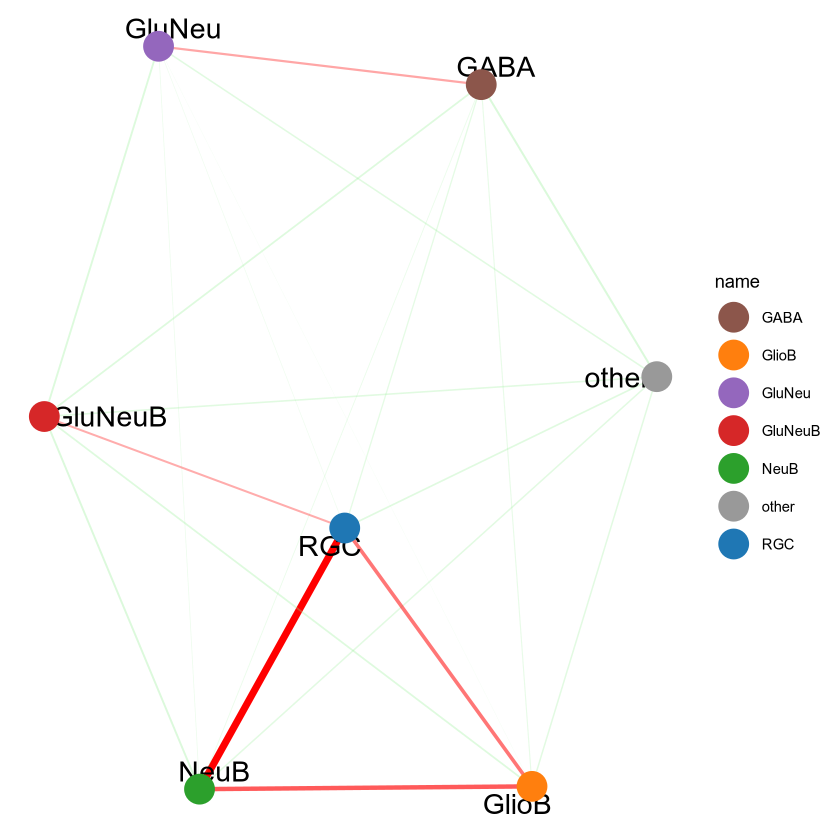

In [14]:
cellProximityNetwork(gobject = giotto_high, 
                     CPscore = cell_proximities_high,
                     remove_self_edges = T,
                     self_loop_strength = .3,
                     only_show_enrichment_edges = F,
                     rescale_edge_weights = T,
                     node_size = 8,
                     node_color_code = c('#8c564b', '#ff7f0e', '#9467bd', '#d62728', '#2ca02c', '#999999', '#1f77b4'), # GABA, GlioB, GluNeu, GluNeuB, NeuB, other, RGC
                     edge_weight_range_depletion = c(1, 2),
                     edge_weight_range_enrichment = c(2,5))
ggsave('CellProximityNetwork_high_4.pdf', width= 6, height=6)

## L-R

In [50]:
giotto_high <- filterGiotto(gobject = giotto_high,
                           expression_threshold = 1,
                           feat_det_in_min_cells = 10,
                           min_det_feats_per_cell = 10,
                           expression_values = c('raw'),
                           verbose = T)

completed 1: preparation 
completed 2: subset expression data 
completed 3: subset spatial locations 
completed 4: subset cell metadata 
completed 5: subset feature metadata 
completed 6: subset spatial network(s) 
completed 7: subsetted dimension reductions 
completed 8: subsetted nearest network(s) 
completed 9: subsetted spatial enrichment results 

Feature type:  rna 
Number of cells removed:  0  out of  3076 
Number of feats removed:  8344  out of  19330 


In [51]:
# normalize
giotto_high <- normalizeGiotto(gobject = giotto_high, scalefactor = 6000, verbose = T)
# add gene & cell statistics
giotto_high <- addStatistics(gobject = giotto_high)
# adjust expression matrix for technical or known variables
giotto_high <- adjustGiottoMatrix(gobject = giotto_high, expression_values = c('normalized'),
                                 covariate_columns = c('nr_feats', 'total_expr'),
                                 return_gobject = TRUE,
                                 update_slot = c('custom'))


first scale feats and then cells



In [52]:
LR_data = data.table::fread("../../../../SpatComTrajectory/source/mouse_ligand_receptors.txt")
LR_data[, ligand_det := ifelse(LR_data$mouseLigand %in% giotto_high@feat_ID$rna, T, F)]
LR_data[, receptor_det := ifelse(LR_data$mouseReceptor %in% giotto_high@feat_ID$rna, T, F)]
LR_data_det = LR_data[ligand_det == T & receptor_det == T]
select_ligands = LR_data_det$mouseLigand
select_receptors = LR_data_det$mouseReceptor

In [53]:
## get statistical significance of gene pair expression changes based on expression
expr_only_scores_high = exprCellCellcom(gobject = giotto_high,
                                   cluster_column = 'cell_types', 
                                   random_iter = 1000,
                                   feat_set_1 = select_ligands,
                                   feat_set_2 = select_receptors, 
                                   verbose = FALSE)

In [54]:
options(future.globals.maxSize= 1000*1024^2)

## get statistical significance of gene pair expression changes upon cell-cell interaction
spatial_all_scores_high = spatCellCellcom(giotto_high,
                                     spatial_network_name = 'spatial_network',
                                     cluster_column = 'cell_types', 
                                     random_iter = 1000,
                                     feat_set_1 = select_ligands,
                                     feat_set_2 = select_receptors,
                                     adjust_method = 'fdr',
                                     do_parallel = T,
                                     cores = 4,
                                     verbose = 'a little')

simulation  1 
simulation  2 
simulation  3 
simulation  4 
simulation  5 
simulation  6 
simulation  7 
simulation  8 
simulation  9 
simulation  10 
simulation  11 
simulation  12 
simulation  13 
simulation  14 
simulation  15 
simulation  16 
simulation  17 
simulation  18 
simulation  19 
simulation  20 
simulation  21 
simulation  22 
simulation  23 
simulation  24 
simulation  25 
simulation  26 
simulation  27 
simulation  28 
simulation  29 
simulation  30 
simulation  31 
simulation  32 
simulation  33 
simulation  34 
simulation  35 
simulation  36 
simulation  37 
simulation  38 
simulation  39 
simulation  40 
simulation  41 
simulation  42 
simulation  43 
simulation  44 
simulation  45 
simulation  46 
simulation  47 
simulation  48 
simulation  49 
simulation  50 
simulation  51 
simulation  52 
simulation  53 
simulation  54 
simulation  55 
simulation  56 
simulation  57 
simulation  58 
simulation  59 
simulation  60 
simulation  61 
simulation  62 
simulation  63 
s

In [55]:
saveRDS(giotto_high, 'giotto_high_4.rds')

In [63]:
saveRDS(spatial_all_scores_high, 'spatial_all_scores_high_4.rds')

In [57]:
giotto_high = readRDS('giotto_high_4.rds')
spatial_all_scores_high = readRDS('spatial_all_scores_high_4.rds')

Saving 6.67 x 6.67 in image


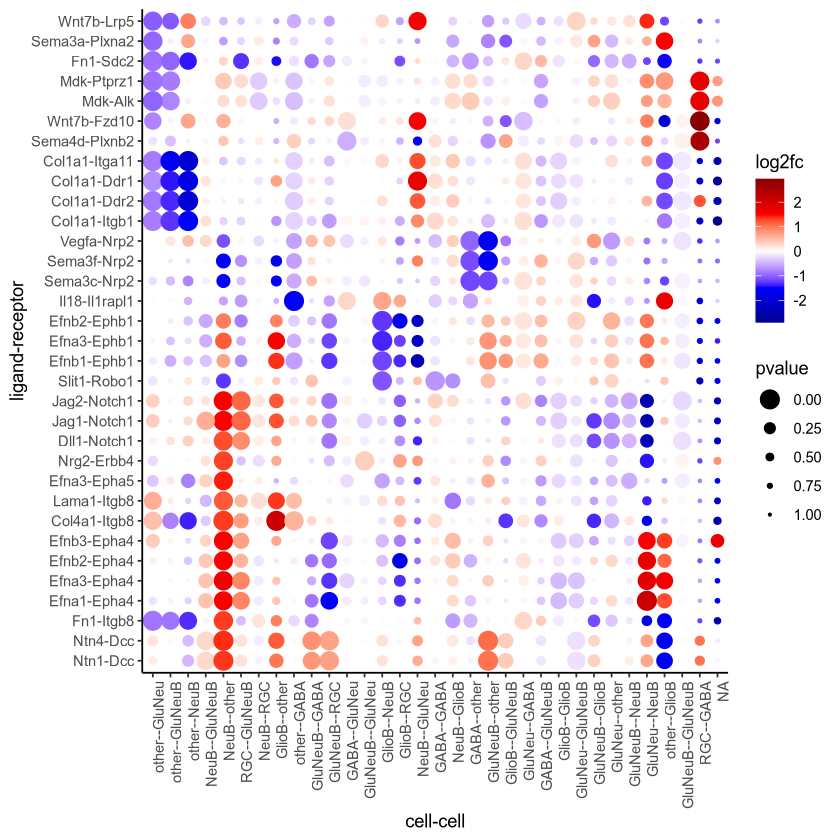

In [59]:
## select top LR ##
selected_spat = spatial_all_scores_high[pvalue <= 0.05 & abs(log2fc) > 0.25 & lig_nr >= 4 & rec_nr >= 4]
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]
plotCCcomDotplot(gobject = giotto_high,
                 comScores = spatial_all_scores_high,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 cluster_on = 'PI')
ggsave("Dotplot_high_4.pdf")

Saving 6.67 x 6.67 in image


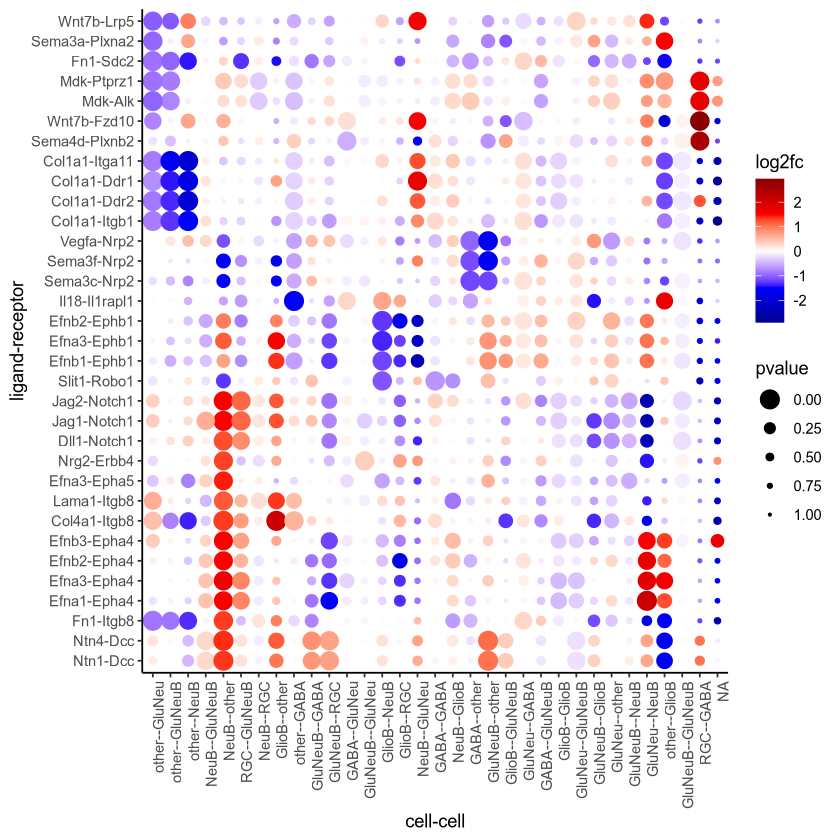

In [61]:
selected_spat = spatial_all_scores_high[pvalue <= 0.05 & abs(log2fc) > 0.25 & lig_nr >= 4 & rec_nr >= 4]
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]
plotCCcomDotplot(gobject = giotto_high,
                 comScores = spatial_all_scores_high,
                 selected_LR = top_LR_ints,
                 selected_cell_LR = top_LR_cell_ints,
                 cluster_on = 'PI')
ggsave("Dotplot_high_all_4.pdf")

In [66]:
giotto_high = readRDS('giotto_high_4.rds')
spatial_all_scores_high = readRDS('spatial_all_scores_high_4.rds')
cell_proximities_high = readRDS('cell_proximities_4_high.rds')

In [67]:
write.csv(cell_proximities_high$enrichm_res, 'cell_proximities_4_high.csv')

In [68]:
cell_proximities_high$enrichm_res

unified_int,type_int,original,simulations,enrichm,p_higher_orig,p_lower_orig,p.adj_higher,p.adj_lower,PI_value,int_ranking,cell_1,cell_2
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
GlioB--GlioB,homo,240,18.523,3.62578648,0.000,1.000,0.000000000,1.000,10.87735944,1,GlioB,GlioB
RGC--RGC,homo,64,9.463,2.63514315,0.000,1.000,0.000000000,1.000,7.90542945,2,RGC,RGC
NeuB--NeuB,homo,593,111.385,2.40201344,0.000,1.000,0.000000000,1.000,7.20604032,3,NeuB,NeuB
other--other,homo,1081,252.368,2.09439427,0.000,1.000,0.000000000,1.000,6.28318280,4,other,other
NeuB--RGC,hetero,257,65.595,1.95388530,0.000,1.000,0.000000000,1.000,5.86165589,5,NeuB,RGC
GABA--GABA,homo,182,50.736,1.82260323,0.000,1.000,0.000000000,1.000,5.46780968,6,GABA,GABA
GluNeuB--GluNeuB,homo,712,223.172,1.66929599,0.000,1.000,0.000000000,1.000,5.00788796,7,GluNeuB,GluNeuB
GlioB--NeuB,hetero,187,91.274,1.02673656,0.000,1.000,0.000000000,1.000,3.08020968,8,GlioB,NeuB
GluNeu--GluNeu,homo,2675,1422.662,0.91047145,0.000,1.000,0.000000000,1.000,2.73141434,9,GluNeu,GluNeu


In [69]:
selected_spat = spatial_all_scores_high
data.table::setorder(selected_spat, -PI)
top_LR_ints = unique(selected_spat[order(-abs(PI))]$LR_comb)[1:33]
top_LR_cell_ints = unique(selected_spat[order(-abs(PI))]$LR_cell_comb)[1:33]


In [70]:
gobject = giotto_high
comScores = spatial_all_scores_high
selected_LR = top_LR_ints
selected_cell_LR = top_LR_cell_ints
show_LR_names = TRUE
show_cell_LR_names = TRUE
cluster_on = 'PI'
cor_method = c("pearson", "kendall", "spearman")
aggl_method = c("ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", "centroid")
dot_color_gradient = NULL
gradient_style = c('divergent', 'sequential')
show_plot = NA
return_plot = NA
save_plot = NA
save_param =  list()
default_save_name = 'plotCCcomDotplot'

In [71]:
# get parameters
cor_method = match.arg(cor_method, choices = c("pearson", "kendall", "spearman"))
aggl_method = match.arg(aggl_method, choices = c("ward.D", "ward.D2", "single", "complete",
                                               "average", "mcquitty", "median", "centroid"))


# data.table variables
LR_comb = LR_cell_comb = sd = NULL

# plot method
if(!is.null(selected_LR) & !is.null(selected_cell_LR)) {
selDT = comScores[LR_comb %in% selected_LR & LR_cell_comb %in% selected_cell_LR]
} else if(!is.null(selected_LR)) {
selDT = comScores[LR_comb %in% selected_LR]
} else if(!is.null(selected_cell_LR)) {
selDT = comScores[LR_cell_comb %in% selected_cell_LR]
} else {
selDT = comScores
}

In [72]:
# creat matrix
cluster_on = match.arg(cluster_on, choices = c('PI', 'LR_expr', 'log2fc'))
selDT_d = data.table::dcast.data.table(selDT, LR_cell_comb~LR_comb, value.var = cluster_on, fill = 0)
selDT_m = dt_to_matrix(selDT_d)

# remove zero variance
sd_rows = apply(selDT_m, 1, sd)
sd_rows_zero = names(sd_rows[sd_rows == 0])
if(length(sd_rows_zero) > 0) selDT_m = selDT_m[!rownames(selDT_m) %in% sd_rows_zero, ]

sd_cols = apply(selDT_m, 2, sd)
sd_cols_zero = names(sd_cols[sd_cols == 0])
if(length(sd_cols_zero) > 0) selDT_m = selDT_m[, !colnames(selDT_m) %in% sd_cols_zero]

In [73]:
## cells
corclus_cells_dist = stats::as.dist(1-cor_flex(x = t_flex(selDT_m), method = cor_method))
hclusters_cells = stats::hclust(d = corclus_cells_dist, method = aggl_method)
clus_names = rownames(selDT_m)
names(clus_names) = 1:length(clus_names)
clus_sort_names = clus_names[hclusters_cells$order]
selDT[, LR_cell_comb := factor(LR_cell_comb, clus_sort_names)]

## genes
corclus_genes_dist = stats::as.dist(1-cor_flex(x = selDT_m, method = cor_method))
hclusters_genes = stats::hclust(d = corclus_genes_dist, method = aggl_method)
clus_names = colnames(selDT_m)
names(clus_names) = 1:length(clus_names)
clus_sort_names = clus_names[hclusters_genes$order]
selDT[, LR_comb := factor(LR_comb, clus_sort_names)]

In [74]:
selDT = selDT[(selDT$lig_cell_type != 'other') & (selDT$rec_cell_type != 'other'), ]

In [75]:
head(selDT)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Wnt7b-Fzd10,GlioB,0.000000,Wnt7b,GABA,2.1990199,Fzd10,2.199020,3,4,0.08939498,2.109625,3.601549,0.001,GlioB--GABA,0.2300000,2.298768
Pdgfc-Pdgfra,GABA,0.643764,Pdgfc,NeuB,1.3655157,Pdgfra,2.009280,5,3,0.08442060,1.924859,3.515679,0.000,GABA--NeuB,0.0000000,2.243960
Bmp7-Acvr2b,NeuB,1.261011,Bmp7,GABA,0.6437640,Acvr2b,1.904775,3,5,0.08455733,1.820218,3.441299,0.001,NeuB--GABA,0.2300000,2.196486
Efnb3-Ephb3,GABA,1.035739,Efnb3,GlioB,0.9333202,Ephb3,1.969060,4,3,0.14077985,1.828280,3.103189,0.001,GABA--GlioB,0.2300000,1.980679
Wnt7b-Fzd10,RGC,0.000000,Wnt7b,GABA,2.1990199,Fzd10,2.199020,4,4,0.19809905,2.000921,2.947155,0.001,RGC--GABA,0.2300000,1.881087
Pdgfa-Pdgfra,GABA,0.000000,Pdgfa,NeuB,1.3655157,Pdgfra,1.365516,5,3,0.04170359,1.323812,3.370460,0.007,GABA--NeuB,0.3066667,1.730170


In [76]:
table(selDT$lig_cell_type)


   GABA    NeuB   other GluNeuB   GlioB     RGC  GluNeu 
    132      99       0     165     132      66     132 

In [77]:
table(selDT$rec_cell_type)


   GABA    NeuB   other GluNeuB   GlioB     RGC  GluNeu 
    165     132       0     165     132      99      33 

In [78]:
table(selDT$LR_cell_comb)


     GlioB--GABA        RGC--GABA GluNeuB--GluNeuB    GluNeuB--NeuB 
              33               33               33               33 
  GluNeuB--GlioB     GluNeu--NeuB    GluNeu--other      GlioB--NeuB 
              33               33                0               33 
    other--other       GlioB--RGC     GluNeuB--RGC      GABA--GlioB 
               0               33               33               33 
      NeuB--GABA     GluNeu--GABA       GABA--GABA      NeuB--GlioB 
              33               33               33               33 
      GABA--NeuB      GluNeu--RGC  GluNeuB--GluNeu  GluNeu--GluNeuB 
              33               33               33               33 
   GABA--GluNeuB     GlioB--GlioB     other--GlioB    other--GluNeu 
              33               33                0                0 
  other--GluNeuB      other--NeuB      GABA--other   GluNeuB--other 
               0                0                0                0 
   NeuB--GluNeuB      NeuB--other

In [79]:
pl = ggplot2::ggplot()
pl = pl + ggplot2::geom_point(data = selDT, aes_string(x = 'LR_cell_comb',
                                                     y = 'LR_comb', size = 'pvalue', color = 'log2fc'))
pl = pl + ggplot2::theme_classic()
if(show_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.y = element_text(),
                                                 axis.ticks.y = element_line())
if(show_cell_LR_names == TRUE) pl = pl + ggplot2::theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
                                                      axis.ticks.x = element_line())
pl = pl + set_default_color_continuous_CCcom_dotplot(
colors = dot_color_gradient,
instrs = instructions(gobject),
midpoint = NULL,
style = gradient_style,
type = 'fill'
)
pl = pl + ggplot2::scale_size_continuous(range = c(5, 0.5)) +
set_default_color_continuous_CCcom_dotplot(
  colors = dot_color_gradient,
  instrs = instructions(gobject),
  midpoint = NULL,
  style = gradient_style,
  type = 'color'
)
pl = pl + ggplot2::labs(x = 'cell-cell', y = 'ligand-receptor')

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


Saving 6.67 x 6.67 in image


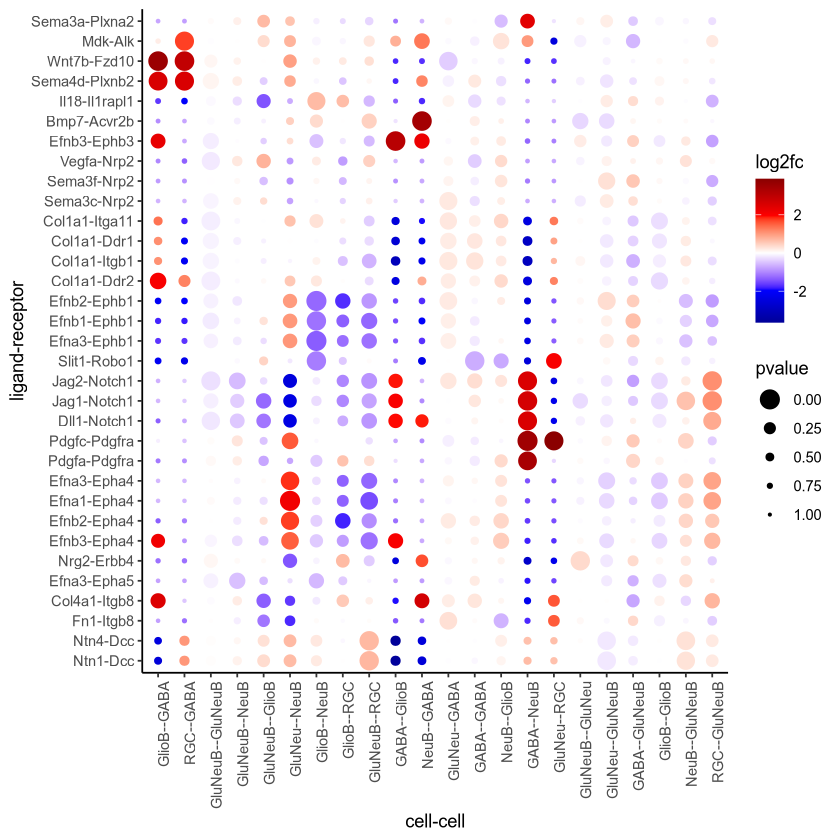

In [80]:
pl
ggsave("Dotplot_high_all_4.pdf")

# High VS. Low

In [109]:
write.table(spatial_all_scores_low, 'spatial_all_scores_low.csv')
write.table(spatial_all_scores_high, 'spatial_all_scores_high.csv')

In [81]:
head(spatial_all_scores_low)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Adam17-Itgb1,GlioB,0.3013547,Adam17,NeuB,1.0909136,Itgb1,1.3922683,7,10,0.4275697,0.964698581,1.50007336,0.024,GlioB--NeuB,0.2590000,0.880093395
Adam17-Itgb1,NeuB,0.0000000,Adam17,other,1.2462946,Itgb1,1.2462946,7,5,0.4044615,0.841833095,1.41617811,0.131,NeuB--other,0.8078333,0.131248882
Adam17-Itgb1,GlioB,0.2152533,Adam17,GlioB,0.6172454,Itgb1,0.8324987,14,14,0.7682069,0.064291862,0.10306293,0.625,GlioB--GlioB,1.0000000,0.000000000
Adam17-Itgb1,GABA,0.0000000,Adam17,other,0.7258348,Itgb1,0.7258348,12,12,0.4249860,0.300848840,0.65357435,0.432,GABA--other,0.8828966,0.035351954
Adam17-Itgb1,RGC,0.0000000,Adam17,GlioB,0.6847161,Itgb1,0.6847161,17,28,0.6785123,0.006203804,0.01145097,0.945,RGC--GlioB,0.9712500,0.000145072
Adam17-Itgb1,GluNeuB,0.1569827,Adam17,other,0.4749196,Itgb1,0.6319024,24,19,0.4817592,0.150143209,0.33122920,0.517,GluNeuB--other,0.8721429,0.019679112


In [82]:
head(spatial_all_scores_high)

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Wnt7b-Fzd10,GlioB,0.00000000,Wnt7b,GABA,2.1990199,Fzd10,2.1990199,3,4,0.08939498,2.1096249,3.601549,0.001,GlioB--GABA,0.2300,2.298768
Pdgfc-Pdgfra,GABA,0.64376396,Pdgfc,NeuB,1.3655157,Pdgfra,2.0092797,5,3,0.08442060,1.9248591,3.515679,0.000,GABA--NeuB,0.0000,2.243960
Bmp7-Acvr2b,NeuB,1.26101102,Bmp7,GABA,0.6437640,Acvr2b,1.9047750,3,5,0.08455733,1.8202176,3.441299,0.001,NeuB--GABA,0.2300,2.196486
Efna3-Epha4,NeuB,0.04358834,Efna3,other,0.4718664,Epha4,0.5154547,63,36,0.09641367,0.4190410,1.647757,0.002,NeuB--other,0.0575,2.043766
Efnb3-Ephb3,GABA,1.03573949,Efnb3,GlioB,0.9333202,Ephb3,1.9690597,4,3,0.14077985,1.8282799,3.103189,0.001,GABA--GlioB,0.2300,1.980679
Jag1-Notch1,NeuB,0.06971932,Jag1,other,0.5285364,Notch1,0.5982557,63,36,0.14105340,0.4572023,1.534403,0.000,NeuB--other,0.0000,1.903169


In [83]:
dim(spatial_all_scores_low)
dim(spatial_all_scores_high)

[1] 1258   17

[1] 10810    17

In [84]:
length(unique(spatial_all_scores_low$LR_comb))

[1] 37

In [85]:
length(unique(spatial_all_scores_high$LR_comb))

[1] 230

In [86]:
dim(LR_data)

[1] 1067    4

In [87]:
common_LR = intersect(unique(spatial_all_scores_low$LR_comb), unique(spatial_all_scores_high$LR_comb))

In [88]:
dim(spatial_all_scores_high[spatial_all_scores_high$LR_comb %in% common_LR,])

[1] 1739   17

In [89]:
temp1 = spatial_all_scores_low %>%
  inner_join(spatial_all_scores_high, by = c("LR_comb", "LR_cell_comb"))
dim(temp1)

[1] 1258   32

In [108]:
head(temp1)

LR_comb,lig_cell_type.x,lig_expr.x,ligand.x,rec_cell_type.x,rec_expr.x,receptor.x,LR_expr.x,lig_nr.x,rec_nr.x,⋯,receptor.y,LR_expr.y,lig_nr.y,rec_nr.y,rand_expr.y,av_diff.y,log2fc.y,pvalue.y,p.adj.y,PI.y
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,⋯,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adam17-Itgb1,GlioB,0.3013547,Adam17,NeuB,1.0909136,Itgb1,1.3922683,7,10,⋯,Itgb1,0.3206640,104,84,0.3319721,-0.011308107,-0.03826980,0.900,1.0000000,0.0000000000
Adam17-Itgb1,NeuB,0.0000000,Adam17,other,1.2462946,Itgb1,1.2462946,7,5,⋯,Itgb1,0.3042064,63,36,0.4383063,-0.134099956,-0.41333534,0.522,0.8148171,-0.0367619951
Adam17-Itgb1,GlioB,0.2152533,Adam17,GlioB,0.6172454,Itgb1,0.8324987,14,14,⋯,Itgb1,0.3694406,122,122,0.3478967,0.021543918,0.06777664,0.692,0.9921569,0.0002317730
Adam17-Itgb1,GABA,0.0000000,Adam17,other,0.7258348,Itgb1,0.7258348,12,12,⋯,Itgb1,0.4299388,108,152,0.4206187,0.009320087,0.02559859,0.860,0.9653521,0.0003920232
Adam17-Itgb1,RGC,0.0000000,Adam17,GlioB,0.6847161,Itgb1,0.6847161,17,28,⋯,Itgb1,0.3566027,28,32,0.3428656,0.013737140,0.04407058,0.873,1.0000000,0.0000000000
Adam17-Itgb1,GluNeuB,0.1569827,Adam17,other,0.4749196,Itgb1,0.6319024,24,19,⋯,Itgb1,0.1890650,86,85,0.4092212,-0.220156113,-0.81689820,0.056,0.5257143,-0.2281190031


In [90]:
library(dplyr)

result <- spatial_all_scores_low %>%
  inner_join(spatial_all_scores_high, by = c("LR_comb", "LR_cell_comb")) %>%
  mutate(new_log2fc = log2fc.y - log2fc.x) %>%
  select(LR_comb, LR_cell_comb, new_log2fc)

In [91]:
dim(result)

[1] 1258    3

In [92]:
spatial_all_scores_low[spatial_all_scores_low$LR_comb == 'Adam17-Itgb1' & spatial_all_scores_low$LR_cell_comb == 'GlioB--NeuB',]

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Adam17-Itgb1,GlioB,0.3013547,Adam17,NeuB,1.090914,Itgb1,1.392268,7,10,0.4275697,0.9646986,1.500073,0.024,GlioB--NeuB,0.259,0.8800934


In [93]:
spatial_all_scores_high[spatial_all_scores_high$LR_comb == 'Adam17-Itgb1' & spatial_all_scores_high$LR_cell_comb == 'GlioB--NeuB',]

LR_comb,lig_cell_type,lig_expr,ligand,rec_cell_type,rec_expr,receptor,LR_expr,lig_nr,rec_nr,rand_expr,av_diff,log2fc,pvalue,LR_cell_comb,p.adj,PI
<chr>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Adam17-Itgb1,GlioB,0.07122609,Adam17,NeuB,0.2494379,Itgb1,0.320664,104,84,0.3319721,-0.01130811,-0.0382698,0.9,GlioB--NeuB,1,0


In [94]:
head(result)

LR_comb,LR_cell_comb,new_log2fc
<chr>,<chr>,<dbl>
Adam17-Itgb1,GlioB--NeuB,-1.53834316
Adam17-Itgb1,NeuB--other,-1.82951345
Adam17-Itgb1,GlioB--GlioB,-0.03528629
Adam17-Itgb1,GABA--other,-0.62797576
Adam17-Itgb1,RGC--GlioB,0.03261961
Adam17-Itgb1,GluNeuB--other,-1.14812740


In [95]:
sort(unique(result$LR_cell_comb))

[1] "GABA--GABA"       "GABA--GluNeuB"    "GABA--other"      "GABA--RGC"       
 [5] "GlioB--GlioB"     "GlioB--GluNeuB"   "GlioB--NeuB"      "GlioB--RGC"      
 [9] "GluNeu--GluNeuB"  "GluNeu--RGC"      "GluNeuB--GABA"    "GluNeuB--GlioB"  
[13] "GluNeuB--GluNeu"  "GluNeuB--GluNeuB" "GluNeuB--NeuB"    "GluNeuB--other"  
[17] "GluNeuB--RGC"     "NeuB--GlioB"      "NeuB--GluNeuB"    "NeuB--NeuB"      
[21] "NeuB--other"      "NeuB--RGC"        "other--GABA"      "other--GluNeuB"  
[25] "other--NeuB"      "other--other"     "other--RGC"       "RGC--GABA"       
[29] "RGC--GlioB"       "RGC--GluNeu"      "RGC--GluNeuB"     "RGC--NeuB"       
[33] "RGC--other"       "RGC--RGC"

In [96]:
length(unique(result$LR_cell_comb))

[1] 34

In [106]:
# Reshape the data for the heatmap
heatmap_data <- reshape2::dcast(result, LR_comb ~ LR_cell_comb, value.var = "new_log2fc")

# Convert to matrix, removing row names for clustering
heatmap_matrix <- as.matrix(heatmap_data[, -1])
row.names(heatmap_matrix) <- heatmap_data$LR_comb

# Order the columns as per your requirement
column_order <- c("RGC--RGC", "RGC--GlioB", "RGC--NeuB", "RGC--GluNeuB", "RGC--GluNeu", "RGC--GABA", "RGC--other",
                  "GlioB--RGC", "GlioB--GlioB", "GlioB--NeuB", "GlioB--GluNeuB",
                  "NeuB--RGC", "NeuB--GlioB", "NeuB--NeuB", "NeuB--GluNeuB", "NeuB--other",
                  "GluNeuB--RGC", "GluNeuB--GlioB", "GluNeuB--NeuB", "GluNeuB--GluNeuB", "GluNeuB--GluNeu", "GluNeuB--GABA", "GluNeuB--other",
                  "GluNeu--RGC", "GluNeu--GluNeuB", 
                  "GABA--RGC", "GABA--GluNeuB", "GABA--GABA", "GABA--other",
                  'other--RGC','other--NeuB','other--GluNeuB', 'other--GABA','other--other'
                 )
heatmap_matrix <- heatmap_matrix[, column_order]

# Draw the heatmap
# pheatmap(heatmap_matrix,
#          cluster_cols = F,
#          clustering_distance_rows = "euclidean",
#                    clustering_distance_cols = "euclidean",
#                    clustering_method = "complete",
#                    scale = "row")

png 
  2

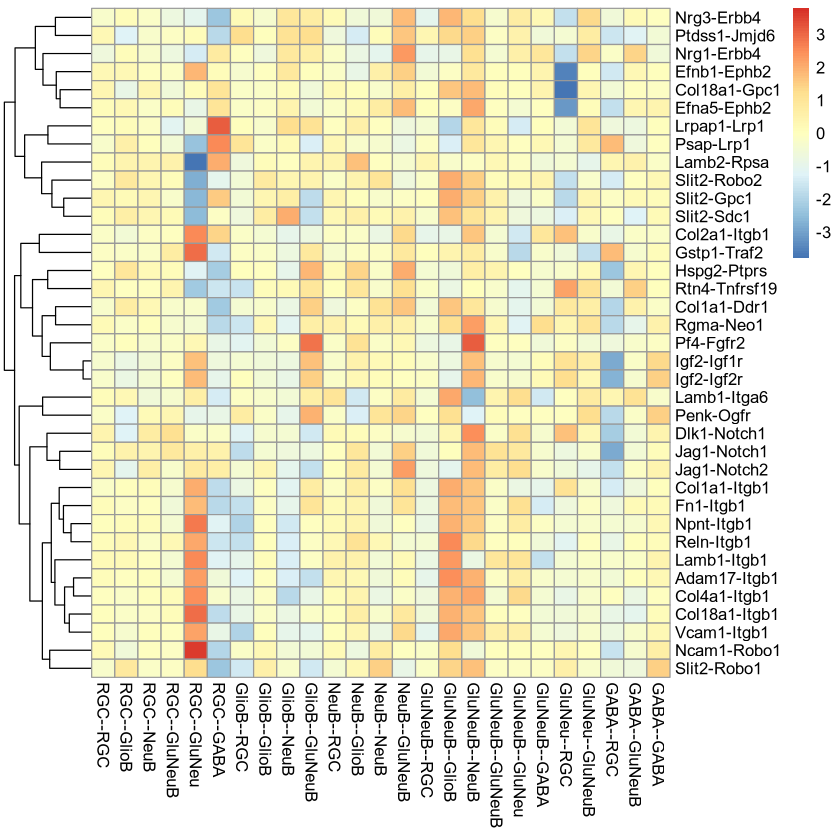

In [107]:
# Reshape the data for the heatmap
heatmap_data <- reshape2::dcast(result, LR_comb ~ LR_cell_comb, value.var = "new_log2fc")

# Convert to matrix, removing row names for clustering
heatmap_matrix <- as.matrix(heatmap_data[, -1])
row.names(heatmap_matrix) <- heatmap_data$LR_comb

# Order the columns as per your requirement
column_order <- c("RGC--RGC", "RGC--GlioB", "RGC--NeuB", "RGC--GluNeuB", "RGC--GluNeu", "RGC--GABA",
                  "GlioB--RGC", "GlioB--GlioB", "GlioB--NeuB", "GlioB--GluNeuB",
                  "NeuB--RGC", "NeuB--GlioB", "NeuB--NeuB", "NeuB--GluNeuB",
                  "GluNeuB--RGC", "GluNeuB--GlioB", "GluNeuB--NeuB", "GluNeuB--GluNeuB", "GluNeuB--GluNeu", "GluNeuB--GABA",
                  "GluNeu--RGC", "GluNeu--GluNeuB", 
                  "GABA--RGC", "GABA--GluNeuB", "GABA--GABA")
heatmap_matrix <- heatmap_matrix[, column_order]

# Draw the heatmap
p = pheatmap(heatmap_matrix,
         cluster_cols = F,
         clustering_distance_rows = "euclidean",
                   clustering_distance_cols = "euclidean",
                   clustering_method = "complete",
                   scale = "row")
pdf("Dotplot_LR_change_high_VS_low_4.pdf")

grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

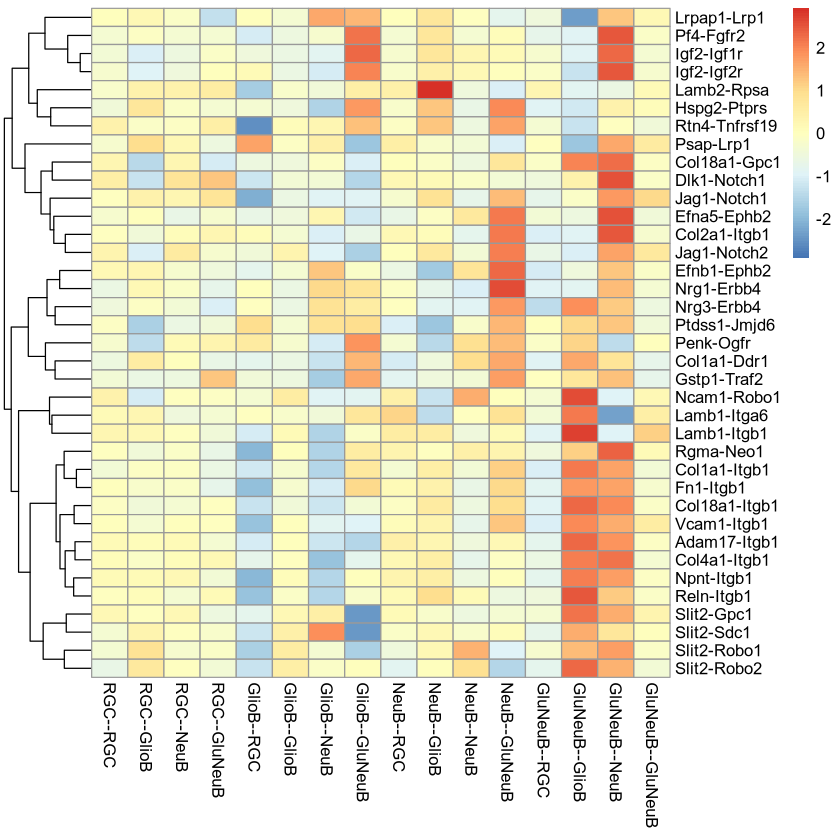

In [110]:
# Reshape the data for the heatmap
heatmap_data <- reshape2::dcast(result, LR_comb ~ LR_cell_comb, value.var = "new_log2fc")

# Convert to matrix, removing row names for clustering
heatmap_matrix <- as.matrix(heatmap_data[, -1])
row.names(heatmap_matrix) <- heatmap_data$LR_comb

# Order the columns as per your requirement
column_order <- c("RGC--RGC", "RGC--GlioB", "RGC--NeuB", "RGC--GluNeuB",
            "GlioB--RGC", "GlioB--GlioB", "GlioB--NeuB", "GlioB--GluNeuB",
            "NeuB--RGC", "NeuB--GlioB", "NeuB--NeuB", "NeuB--GluNeuB",
            "GluNeuB--RGC", "GluNeuB--GlioB", "GluNeuB--NeuB", "GluNeuB--GluNeuB")
heatmap_matrix <- heatmap_matrix[, column_order]

# Draw the heatmap
p = pheatmap(heatmap_matrix,
         cluster_cols = F,
         clustering_distance_rows = "euclidean",
                   clustering_distance_cols = "euclidean",
                   clustering_method = "complete",
                   scale = "row")
# pdf("Dotplot_LR_change_high_VS_low_4.pdf")

# grid::grid.newpage()
# grid::grid.draw(p$gtable)
# dev.off()

In [1]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Rocky Linux 9.4 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /sc/arion/work/wangw32/conda-env/envs/giotto_suite/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.utf8        LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] plotly_4.10.4       utf8_1.2.4          generics_0.1.3     
 [4] tidyr_1.3.1         gtools_3.9.5        stringi_1.8.4      
 [7] lattice_0.22-6      digest_0.6.37       magrittr_2.0.